In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop

from utils import get_imagens_erro, report, plot_errors
import time

OLD_MODEL_DIR = '../modelschest'
MODEL_DIR = '../modelschest_densenet121_final'
LOG_DIR = '../logs/02e/chestXRay_densenet121_final'
SIZE = (224, 224)
caminho_bases = os.path.join('..', 'bases', 'chest_xray')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')
caminho_bases_aug = os.path.join('..', 'bases', 'chest_xray_augmented')
caminho_train_aug = os.path.join(caminho_bases_aug, 'train')
caminho_test_aug = os.path.join(caminho_bases_aug, 'test')

# Callbacks

In [2]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=False,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'Transfermodelweights02e.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3,
                              verbose=1, mode='auto')


# Model for feature extraction

In [3]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet',
                         input_shape=(*SIZE, 3),
                         include_top=False,
                         pooling='max')
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# Classifier Model

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=256,
                       activation='relu',
#                        input_shape=(1024,)
                        ))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
classifier = model

# Model Complete

In [5]:
inputA = tf.keras.layers.Input((224, 224, 3))
outputA = base_model(inputA)
outputB = classifier(outputA)
model_complete = tf.keras.Model(inputA, outputB)

In [6]:
for layer in base_model.layers:
    layer.trainable = False   

In [7]:
classifier.load_weights(os.path.join(OLD_MODEL_DIR, '02d.h5'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the model (should be done *after* setting layers to non-trainable)
model_complete.compile(optimizer=Adam(learning_rate=0.0002),
                       loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model_complete.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 262657    
Total params: 7,300,161
Trainable params: 262,657
Non-trainable params: 7,037,504
_________________________________________________________________


# ImageDataGenerator original
## Testar com ImageDataGenerator idêntico ao do passo 02c primeiramente para checar integridade do modelo

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
s = 40 * 32
t0 = time.time()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model_complete, 40)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 5216 images belonging to 2 classes.
1280 imagens processadas em 27.999852895736694 segundos (0.021874885074794292 por imagem)


In [13]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 150 	 7
PNEUMONIA 	 14 	 469
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       157
         1.0       0.99      0.97      0.98       483

    accuracy                           0.97       640
   macro avg       0.95      0.96      0.96       640
weighted avg       0.97      0.97      0.97       640



# ImageDataGenerator augmented

### Não é preciso fazer nenhuma transformação porque já foram feitas no momento da geração da base aumentada. Testar se distribuição bate.

### Como não é preciso fazer nenhuma transformação, o processo de treinamento deve ser bastante acelerado, pois a carga das imagens fica pelo menos 3x mais rápida

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    caminho_train_aug,
    target_size=SIZE,
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
# Pegar 1320 imagens para teste
s = 40 * 32
t0 = time.time()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model_complete, 40)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 14055 images belonging to 2 classes.
1280 imagens processadas em 6.356342792510986 segundos (0.004965892806649208 por imagem)


In [15]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 294 	 23
PNEUMONIA 	 10 	 313
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       317
         1.0       0.93      0.97      0.95       323

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



# Os resultados caíram em relação ao notebook de treinamento original 02d (acc: 0.97 para acc:0.96 com a mesma base e acc:0.94 para base aumentada)

## O ideal seria que tivessem caído menos, mostrando mais estabilidade do modelo, mas como caíram pouco, mostra que pelo menos não ocorreram erros na montagem do modelo e recuperação de pesos, e também que não ocorreram erros na montagem e recuperação da base aumentada. Além disso, o fato de accuracy ter caído pode ter a ver com o desempenho diferente em cada classe  

## Superadas as etapas acima, iniciar fine tunning do modelo final

# DEFINIR QUAL SERIA O ERRO HUMANO E O BAYES ERROR PARA FIXAR UMA META

## Considerar erro de 0.2% como meta inicial. Primeira meta será obter um modelo com "BIAS desejável", isto é, mais de 97% de acerto e mais de 99% de recall para PNEUMONIA

## Somente após atingir este nível, passar para preocupação com variância/generalização

In [16]:
model_complete.save_weights('initial.h5')

In [11]:
model_complete.load_weights('initial.h5')

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    caminho_train_aug,
    target_size=SIZE,
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    caminho_test_aug,
    target_size=SIZE,
    batch_size=8,
    class_mode='binary',
    shuffle=True
)

Found 14055 images belonging to 2 classes.
Found 3503 images belonging to 2 classes.


In [11]:
epoch=0

In [24]:
# Usar linha abaixo para continuar treinamento de uma época específica
val_loss=0
model_complete.load_weights(
    os.path.join(MODEL_DIR,
                 'Transfermodelweights02e.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

OSError: Unable to open file (unable to open file: name = '../modelschest_densenet121_final/Transfermodelweights02e.00-0.00.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
history = model_complete.fit_generator(
    train_generator,
    initial_epoch=epoch,
    epochs=100,
    verbose=1,
    callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
    validation_data=validation_generator)


Epoch 1/100


W0708 18:13:16.910453 139943891773184 deprecation.py:323] From /home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


440/440 [==============================] - 164s 372ms/step - loss: 0.3674 - accuracy: 0.8610 - val_loss: 0.3722 - val_accuracy: 0.8356
Epoch 2/100
440/440 [==============================] - 146s 331ms/step - loss: 0.2378 - accuracy: 0.9039 - val_loss: 0.3579 - val_accuracy: 0.8444
Epoch 3/100
440/440 [==============================] - 146s 332ms/step - loss: 0.2087 - accuracy: 0.9183 - val_loss: 0.3893 - val_accuracy: 0.8204
Epoch 4/100
440/440 [==============================] - 146s 332ms/step - loss: 0.1927 - accuracy: 0.9262 - val_loss: 0.3719 - val_accuracy: 0.8376
Epoch 5/100
439/440 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9279
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00015999999595806003.
440/440 [==============================] - 146s 332ms/step - loss: 0.1826 - accuracy: 0.9279 - val_loss: 0.4680 - val_accuracy: 0.7645
Epoch 6/100
440/440 [==============================] - 145s 330ms/step - loss: 0.1710 - accuracy: 0.9340 - val_

# Treinar 1 camada convolucional
# Fine tunning convolucional 4 e 5

In [13]:
for layer in base_model.layers[313:]:
    layer.trainable = True
for ind, layer in enumerate(base_model.layers):
    print(ind, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [12]:
epoch=0

In [18]:
# Usar linha abaixo para continuar treinamento de uma época específica
val_loss=0
model_complete.load_weights(
    os.path.join(MODEL_DIR,
                 'Transfermodelweights02e_etapa2.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [13]:
model_complete.compile(optimizer=RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
train_generator.reset()
validation_generator.reset()
mcp_save2 = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'Transfermodelweights02e_etapa2.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_accuracy', mode='max')


In [15]:
history = model_complete.fit_generator(
    train_generator,
    initial_epoch=epoch,
    epochs=100,
    verbose=1,
    callbacks=[early_stop, mcp_save2, reduce_lr, tensorboard_logs],
    validation_data=validation_generator)

Epoch 1/100


W0708 18:50:41.295010 139733523851008 deprecation.py:323] From /home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/879 [..............................] - ETA: 8:44:18 - loss: 2.1857 - accuracy: 0.5625

W0708 18:51:16.530457 139733523851008 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.284016). Check your callbacks.


  2/879 [..............................] - ETA: 4:25:39 - loss: 2.3588 - accuracy: 0.5312

W0708 18:51:16.718018 139733523851008 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.240240). Check your callbacks.


879/879 [==============================] - 236s 268ms/step - loss: 0.3885 - accuracy: 0.8670 - val_loss: 0.3973 - val_accuracy: 0.8767
Epoch 2/100
879/879 [==============================] - 187s 213ms/step - loss: 0.1951 - accuracy: 0.9307 - val_loss: 0.5107 - val_accuracy: 0.8390
Epoch 3/100
879/879 [==============================] - 185s 211ms/step - loss: 0.1407 - accuracy: 0.9479 - val_loss: 0.4511 - val_accuracy: 0.8578
Epoch 4/100
878/879 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9646
Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
879/879 [==============================] - 185s 211ms/step - loss: 0.0982 - accuracy: 0.9646 - val_loss: 0.4760 - val_accuracy: 0.8576
Epoch 5/100
879/879 [==============================] - 186s 212ms/step - loss: 0.0824 - accuracy: 0.9694 - val_loss: 0.5066 - val_accuracy: 0.8507
Epoch 6/100
879/879 [==============================] - 186s 211ms/step - loss: 0.0596 - accuracy: 0.9782 - val_l

In [16]:
model_complete.save_weights('finetune.h5')

In [14]:
model_complete.load_weights('finetune.h5')

In [22]:
# Pegar imagens para teste
train_generator.reset()
validation_generator.reset()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model_complete, 100)
y_test, y_pred_test, X_names_test, y_pred_test_proba = get_imagens_erro(validation_generator, model_complete, 100)

In [23]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 684 	 77
PNEUMONIA 	 23 	 816
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       761
         1.0       0.91      0.97      0.94       839

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



In [24]:
report(validation_generator, y_test, y_pred_test)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 206 	 139
PNEUMONIA 	 3 	 452
              precision    recall  f1-score   support

         0.0       0.99      0.60      0.74       345
         1.0       0.76      0.99      0.86       455

    accuracy                           0.82       800
   macro avg       0.88      0.80      0.80       800
weighted avg       0.86      0.82      0.81       800



In [14]:
model_complete.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
mcp_save3 = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'Transfermodelweights02e_etapa2.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='accuracy', mode='max')
early_stop3 = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
reduce_lr3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3,
                              verbose=1, mode='auto')


In [16]:
history = model_complete.fit_generator(
    train_generator,
    initial_epoch=epoch,
    epochs=100,
    verbose=1,
    callbacks=[early_stop3, mcp_save3, reduce_lr3, tensorboard_logs],
    validation_data=validation_generator)

Epoch 1/100


W0708 19:40:55.019873 139801205651200 deprecation.py:323] From /home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/879 [..............................] - ETA: 9:32:38 - loss: 0.0076 - accuracy: 1.0000

W0708 19:41:33.810467 139801205651200 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.292816). Check your callbacks.


  2/879 [..............................] - ETA: 4:48:55 - loss: 0.0053 - accuracy: 1.0000

W0708 19:41:33.979374 139801205651200 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.214331). Check your callbacks.


879/879 [==============================] - 229s 260ms/step - loss: 0.0266 - accuracy: 0.9901 - val_loss: 0.6601 - val_accuracy: 0.8264
Epoch 2/100
879/879 [==============================] - 180s 204ms/step - loss: 0.0241 - accuracy: 0.9917 - val_loss: 0.6556 - val_accuracy: 0.8273
Epoch 3/100
879/879 [==============================] - 180s 205ms/step - loss: 0.0249 - accuracy: 0.9906 - val_loss: 0.6794 - val_accuracy: 0.8193
Epoch 4/100
879/879 [==============================] - 180s 204ms/step - loss: 0.0241 - accuracy: 0.9915 - val_loss: 0.6589 - val_accuracy: 0.8256
Epoch 5/100
879/879 [==============================] - 180s 205ms/step - loss: 0.0238 - accuracy: 0.9935 - val_loss: 0.6836 - val_accuracy: 0.8187
Epoch 6/100
879/879 [==============================] - 179s 203ms/step - loss: 0.0229 - accuracy: 0.9919 - val_loss: 0.6854 - val_accuracy: 0.8182
Epoch 7/100
879/879 [==============================] - 178s 202ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.6953 - val_

879/879 [==============================] - 179s 203ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.7351 - val_accuracy: 0.8062
Epoch 49/100
879/879 [==============================] - 178s 202ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.7214 - val_accuracy: 0.8090
Epoch 50/100
879/879 [==============================] - 178s 202ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.7504 - val_accuracy: 0.8027
Epoch 51/100
878/879 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9936
Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.9531249950688334e-09.
879/879 [==============================] - 177s 202ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.7333 - val_accuracy: 0.8062
Epoch 52/100
879/879 [==============================] - 177s 201ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.7401 - val_accuracy: 0.8047


In [ ]:
# Pegar imagens para teste
train_generator.reset()
validation_generator.reset()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model_complete, 500)

In [36]:
y_test, y_pred_test, X_names_test, y_pred_test_proba = get_imagens_erro(validation_generator, model_complete, 300)

In [35]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 3521 	 420
PNEUMONIA 	 95 	 3964
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      3941
         1.0       0.90      0.98      0.94      4059

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000



In [37]:
report(validation_generator, y_test, y_pred_test)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 662 	 400
PNEUMONIA 	 17 	 1321
              precision    recall  f1-score   support

         0.0       0.97      0.62      0.76      1062
         1.0       0.77      0.99      0.86      1338

    accuracy                           0.83      2400
   macro avg       0.87      0.81      0.81      2400
weighted avg       0.86      0.83      0.82      2400



# Testar com as bases originais

In [15]:
model_complete.load_weights(
    os.path.join(MODEL_DIR,
                 'Transfermodelweights02e_etapa2.{:02d}-{:.2f}.hdf5'.format(2, 0.66)
                ))

In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
y_test, y_pred_test, X_names_test, y_pred_test_proba = get_imagens_erro(validation_generator, model_complete)

Found 624 images belonging to 2 classes.


In [28]:
report(validation_generator, y_test, y_pred_test)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 178 	 56
PNEUMONIA 	 12 	 378
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       234
         1.0       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



{0: 'NORMAL', 1: 'PNEUMONIA'}


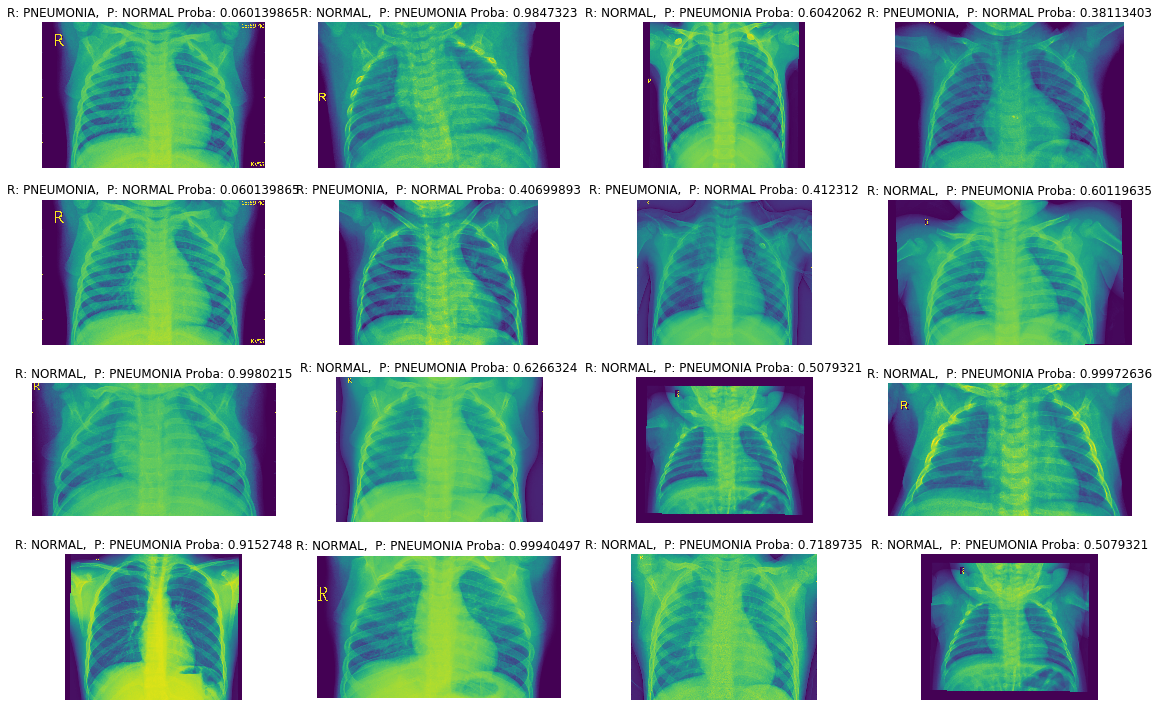

In [21]:
plot_errors(validation_generator, y_test, y_pred_test, caminho_test, X_names_test, y_pred_test_proba)

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
s = len(train_generator) * 32
t0 = time.time()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model_complete)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 5216 images belonging to 2 classes.
5216 imagens processadas em 187.51916360855103 segundos (0.03595075989427742 por imagem)


In [24]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 1269 	 72
PNEUMONIA 	 193 	 3682
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      1341
         1.0       0.98      0.95      0.97      3875

    accuracy                           0.95      5216
   macro avg       0.92      0.95      0.94      5216
weighted avg       0.95      0.95      0.95      5216



In [25]:
print('accuracy: %s' % (sum(np.array(y_train) == np.array(y_pred_train)) / len(y_train)))

accuracy: 0.9491947852760736


{0: 'NORMAL', 1: 'PNEUMONIA'}


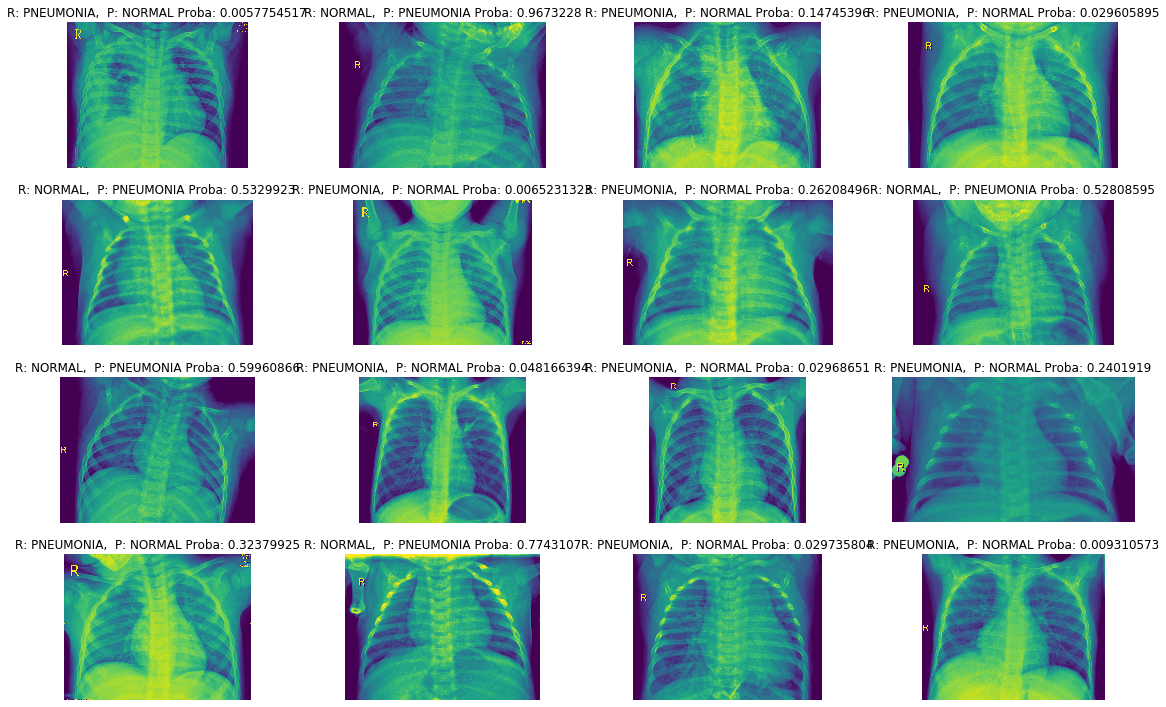

In [26]:
plot_errors(train_generator, y_train, y_pred_train, caminho_train, X_names, y_pred_train_proba)